In [9]:
!pip install -q -q -q geopandas
!pip install -q -q -q rtree

# Interpolation entre des données Insee et un fond de carte

Deux interpolations sont proposées. Dans la première, les statistiques territoriales sont obtenues en sommant les valeurs des carreaux intersectant les unités spatiales du fond de carte. Dans la deuxième, on rajoute une pondération, la part de la surface des carreaux intersectant les unités spatiales. Pour de petits territoires du fait des effets de bord, les résultats des deux approches peuvent être très différents.  

Attention, les calculs peuvent être un peu long en fonction de la puissance de votre machine.


In [1]:
import geopandas as gpd

Chargement des données carroyées et des quartiers de la politique de ville sur Paris

In [2]:
carreaux = gpd.read_file('Filosofi2015_carreaux_200m_metropole.shp')

In [3]:
variables = ["Ind","Men","Men_pauv","Men_1ind","Men_5ind","Men_prop","Men_fmp","Ind_snv",
             "Men_surf","Men_coll","Men_mais","Log_av45","Log_45_70","Log_70_90","Log_ap90",
             "Log_inc","Log_soc","Ind_0_3","Ind_4_5","Ind_6_10","Ind_11_17","Ind_18_24",
             "Ind_25_39","Ind_40_54","Ind_55_64","Ind_65_79","Ind_80p","Ind_inc"]

In [4]:
carreaux = carreaux[["IdINSPIRE", "geometry"] + variables]

In [5]:
carreaux['surface'] = carreaux.geometry.area

In [6]:
qpv = gpd.read_file('QP_METROPOLE_LB93.shp')

### Intersection spatiale entre les deux données spatiales (interpolation spatiale simple)

In [7]:
intersection = gpd.sjoin(qpv, carreaux, how='inner', op='intersects')

In [8]:
intersection.head(2)

,CODE_QP,NOM_QP,COMMUNE_QP,geometry,index_right,IdINSPIRE,Ind,Men,Men_pauv,Men_1ind,...,Ind_6_10,Ind_11_17,Ind_18_24,Ind_25_39,Ind_40_54,Ind_55_64,Ind_65_79,Ind_80p,Ind_inc,surface
0,QP044012,Le Ranzay,Nantes,"POLYGON ((357455.157 6692832.812, 357455.351 6...",823780,CRS3035RES200mN2749600E3451400,236.5,116.0,10.0,39.0,...,9.5,14.5,10.0,51.0,50.0,29.0,37.0,16.0,7.0,39930.618986
0,QP044012,Le Ranzay,Nantes,"POLYGON ((357455.157 6692832.812, 357455.351 6...",830343,CRS3035RES200mN2749600E3451600,434.5,174.0,62.0,81.0,...,38.0,62.0,28.0,77.0,96.0,38.0,36.0,7.0,7.0,39930.623971


Aggrégation des données par qpv

In [10]:
qpv_statistics = intersection.dissolve(by=['CODE_QP', 'NOM_QP'], aggfunc='sum', as_index=False)

In [11]:
qpv_statistics.head(2)

,CODE_QP,NOM_QP,geometry,index_right,Ind,Men,Men_pauv,Men_1ind,Men_5ind,Men_prop,...,Ind_6_10,Ind_11_17,Ind_18_24,Ind_25_39,Ind_40_54,Ind_55_64,Ind_65_79,Ind_80p,Ind_inc,surface
0,QP001001,Grande Reyssouze Terre Des Fleurs,"POLYGON ((872426.099 6570361.000, 872424.911 6...",72404186,8341.0,3837.2,998.0,1733.6,352.2,950.7,...,599.8,791.0,564.7,1512.8,1417.8,925.9,1090.7,606.8,114.5,1.557086e+06
1,QP001002,Croix Blanche,"POLYGON ((873133.502 6569621.231, 873121.870 6...",27884213,2927.0,1385.1,419.6,626.8,123.1,342.2,...,201.5,202.3,165.1,541.3,503.8,394.8,441.0,176.1,23.5,5.988797e+05


### Intersection spatiale entre les deux données spatiales (au prorata de la surface)

In [16]:
intersection = gpd.overlay(qpv, carreaux)

In [18]:
intersection.head(2)

,CODE_QP,NOM_QP,COMMUNE_QP,IdINSPIRE,Ind,Men,Men_pauv,Men_1ind,Men_5ind,Men_prop,...,Ind_11_17,Ind_18_24,Ind_25_39,Ind_40_54,Ind_55_64,Ind_65_79,Ind_80p,Ind_inc,surface,geometry
0,QP044012,Le Ranzay,Nantes,CRS3035RES200mN2749200E3451400,170.5,79.0,16.0,33.0,2.0,33.0,...,19.5,7.5,31.0,36.0,19.0,17.0,10.0,1.0,39930.555798,"POLYGON ((357660.714 6692745.185, 357623.500 6..."
1,QP044012,Le Ranzay,Nantes,CRS3035RES200mN2749400E3451400,476.0,284.0,96.0,174.0,8.0,25.0,...,24.0,31.0,110.0,94.0,66.0,64.0,17.0,1.0,39930.587353,"POLYGON ((357455.157 6692832.812, 357455.351 6..."


Afficher les morceaux de carreaux recouvrant le quartier CODE_QP=='QP044012'

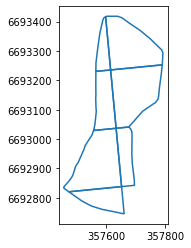

In [20]:
intersection.geometry.boundary[intersection.CODE_QP=='QP044012'].plot()

In [21]:
ponderation = intersection.area / intersection.surface

In [22]:
intersection.loc[:,variables] = intersection.loc[:,variables].mul(ponderation, axis=0)

Aggrégation des données par qpv

In [25]:
qpv_statistics = intersection.dissolve(by=['CODE_QP', 'NOM_QP'], aggfunc='sum', as_index=False)

In [26]:
qpv_statistics.head(2)

,CODE_QP,NOM_QP,geometry,Ind,Men,Men_pauv,Men_1ind,Men_5ind,Men_prop,Men_fmp,...,Ind_6_10,Ind_11_17,Ind_18_24,Ind_25_39,Ind_40_54,Ind_55_64,Ind_65_79,Ind_80p,Ind_inc,surface
0,QP001001,Grande Reyssouze Terre Des Fleurs,"POLYGON ((870591.936 6569670.498, 870594.960 6...",4463.128689,1979.784360,593.610198,874.649782,214.292472,330.103393,268.093968,...,361.842629,450.534883,319.843949,829.397030,754.304031,466.223436,527.668664,285.877116,49.927812,1.557086e+06
1,QP001002,Croix Blanche,"POLYGON ((872954.124 6569376.819, 872925.289 6...",1240.024452,582.541661,216.172140,271.294506,56.474940,72.285039,69.520838,...,90.946806,91.297046,73.432150,238.237154,215.205920,163.724187,173.493772,55.907816,8.143518,5.988797e+05
